DART abs mean pixel error: 55.963478
Run time: 19.42
SART abs mean pixel error: 55.963005


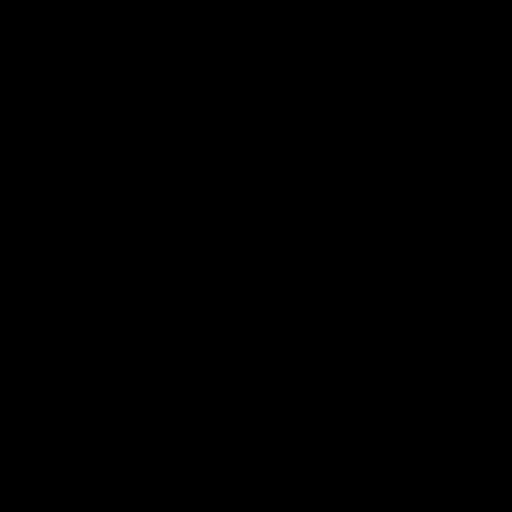

In [3]:
from src.algs import *
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from src.projections import *
from src.phantom_creator import *

# Main parameters
n_projections = 16
n_detectors = 512
det_spacing = 1
noise_factor = 1.1
dart_iters = 10
p = 0.85
rec_alg = 'SART_CUDA'
rec_iters = 1000

# open phantom
img = np.array(Image.open("phantoms/paws/paw_0.png"), dtype=np.uint8)
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
img_width, img_height = img.shape

# prepare all the data
img = np.array(Image.fromarray(img), dtype=np.uint8)
img_width, img_height = img.shape

vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
# make measurements
angles = np.linspace(0, np.pi, n_projections)
projector_id, sino_id, sinogram = project_from_2D(phantom_id=phantom_id,
                                                    vol_geom=vol_geom,
                                                    n_projections=n_projections,
                                                    n_detectors=n_detectors,
                                                    detector_spacing=det_spacing,
                                                    angles=angles,
                                                    noise_factor=noise_factor,
                                                    use_gpu=True)

proj_geom = astra.create_proj_geom('parallel', det_spacing, 
                                        n_detectors, angles)
# instanciate DART
d = DART(gray_levels=gray_lvls, p=p, rec_shape=img.shape,
    proj_geom=proj_geom, projector_id=projector_id,
    sinogram=sinogram)
# run the algorithm
start_ = time.time()
dart_res = d.run(iters=dart_iters,rec_alg=rec_alg,rec_iter=rec_iters)
end_ = time.time()

# run SART for comparison
_, sart_res = SART(vol_geom, 0, projector_id, 
                sino_id, 10000, True)

# print results
print("DART abs mean pixel error:",np.abs(img - dart_res).mean())
print("Run time:", np.round(end_ - start_,2))
print("SART abs mean pixel error:", np.abs(img - sart_res).mean())

Image.fromarray(dart_res.astype(np.uint8))

In [8]:
np.unique(dart_res)

array([0], dtype=uint8)

In [7]:
st = 30000
i = sum([st-(st*c/50) for c in range(50)])
i

765000.0